# L_32 Processing Each Image
#### Steps 1 - 3:

In [1]:
%matplotlib inline

In [ ]:
# Some Helper Functions

def create_folder_if_not_exits(folder_name):
    # May need to update this function if not running within Jupyter notebook, or running in different OS
    if not os.path.isdir(folder_name):
        os.makedirs(folder_name)
    

## 1 - Camera Calibration matrix and Distortion Coefficients
###### (See L_11 for more details)

Determine camera calibration matrix and distortion coefficients for the camera lens.  
Done Once.  
This will be used to undistort each video image frame, before passing it on.  

### Part 1-1: objpoints & imgpoints
- Library Imports


- Prepare arrays to store imgpoints (for img), and gridpattern (objpoints) (of chessboard grid pattern)  
- Use **mgrid** to generate numpy array representing **objpoints**, each corner of the chessboard  
.

- Read in Image,  
- Turn in into grayscale  
.

- Use **findChessBoardCorners** to obtain **imgpoints** (measurements) for the (objpoint locations) in the image  
    - (takes in grayscale image)  
    - (returns imgpoints)  
    - Store imgpoints and corresponding objpoints  

 #### Pickle the objpoints and imgpoints for each image

In [ ]:
# Here are the steps to pickle the objpoints and imgpoints for each image

import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib qt

# Chessboard has 8 inner corners across
#                6 inner corners vertical

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Get and Store chessboard corners for each image as it's Read in

for idx, fname in enumerate(images):
    
    # read in image
    img = cv2.imread(fname)
    # turn it into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners for the image
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If (corners) found, add object points, image points to array of all obj ang img points
    if ret == True:
    
        # same   set of (grid) values for each image -- it's the chessboard pattern
        objpoints.append(objp)
        
        # unique set of values for each image processed (..from findChessboardCorners)
        imgpoints.append(corners)

        # Draw and display the corners (not required)
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
        
# save objpoints and imgpoints to pickle file
objpoints_pickle = {}
objpoints_pickle["objpoints"] = objpoints
objpoints_pickle["imgpoints"] = imgpoints

folder_name = "l32/"
file_name   = "wide_objpoints_pickle.p"
create_folder_if_not_exists(folder_name)
with open( folder_name+file_name, "wb" ) as f:
    pickle.dump( objpoints_pickle, f )
    
print("Imgpoints and Objpoints have been saved to 'calibration_wide/wide_objpoints_pickle.p'")


#### Read objpoints and imgpoints from pickle file

In [ ]:
import pickle

# Read objpoints and imgpoints from pickle file
objpoints_pickle = pickle.load( open( "l32/wide_objpoints_pickle.p", "rb" ) )
objpoints = objpoints_pickle["objpoints"]
imgpoints = objpoints_pickle["imgpoints"]

print("Imgpoints and Objpoints have been read in from 'calibration_wide/wide_objpoints_pickle.p'")


#### Part 1-2: Callibrate and Undistort Images
Calibrate the image (from objpoints and imgpoints - found from findChessboardCorners)  
   - **cv2.calibrateCamera**  
   
Undistort the image  
   - **cv2.undistort**  


In [ ]:
import cv2

# takes in: an image, chessboard grid object points, image's image points (as meassured by findChessboardCorners)
#    - performs the camera calibration (mathematically correlate imgpoints to objpoints), 
#    - undistorts the image (image distortion correction)
# returns: the undistorted image

def cal_undistort(img, objpoints, imgpoints):
    # Uses cv2.calibrateCamera() and cv2.undistort()
    
    # throw away (color depth dim==1) portion of image shape (shape = gray_img.shape[::-1] == gray_img.shape[0:2])
    shape = img.shape[0:2]
    
    # Calibrate imgpoints to the objpoints
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    # Undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist


#### Part 1-3: Display Images: Before (distorted)  and  After (Undistorted)

Read an image (whose imgpoints are stored in imgpoints)  
Calibrate the image (uses imgpoints and objpoints prev found for that image)  
Undistort the image  

.  
Display Distorted and Undistorted image  

.  
This *could* be re-written as a loop, to see before and after for all images that have been processed  

.  
Currently, it displays a before and after only for a single image (==first image that was stored in imgpoints array)  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#   Could loop through all images to show before and after.
#   Here, we only display before and after for a single image..

# Read in an Example image == First Image in Pickled objpoints, imgpoints
img = cv2.imread('calibration_wide/test_image.jpg')

# calibrate and undistort the image
undistorted = cal_undistort(img, objpoints, imgpoints)

# display an Example undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# Before
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

# After
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)

# Show the images
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 2 - Thresholding
###### (See L_21, L_22, L_24, L_29 for more details)

Binary Thresholds images saved as: 
./l32-my-outputs-from-color_and_gradient/l32_bw_binary_s-thresh-180-255_sobel-x-thresh-50-150.png
./l32-my-outputs-from-color_and_gradient/l32_color_binary_s-thresh-180-255_sobel-x-thresh-50-150.png


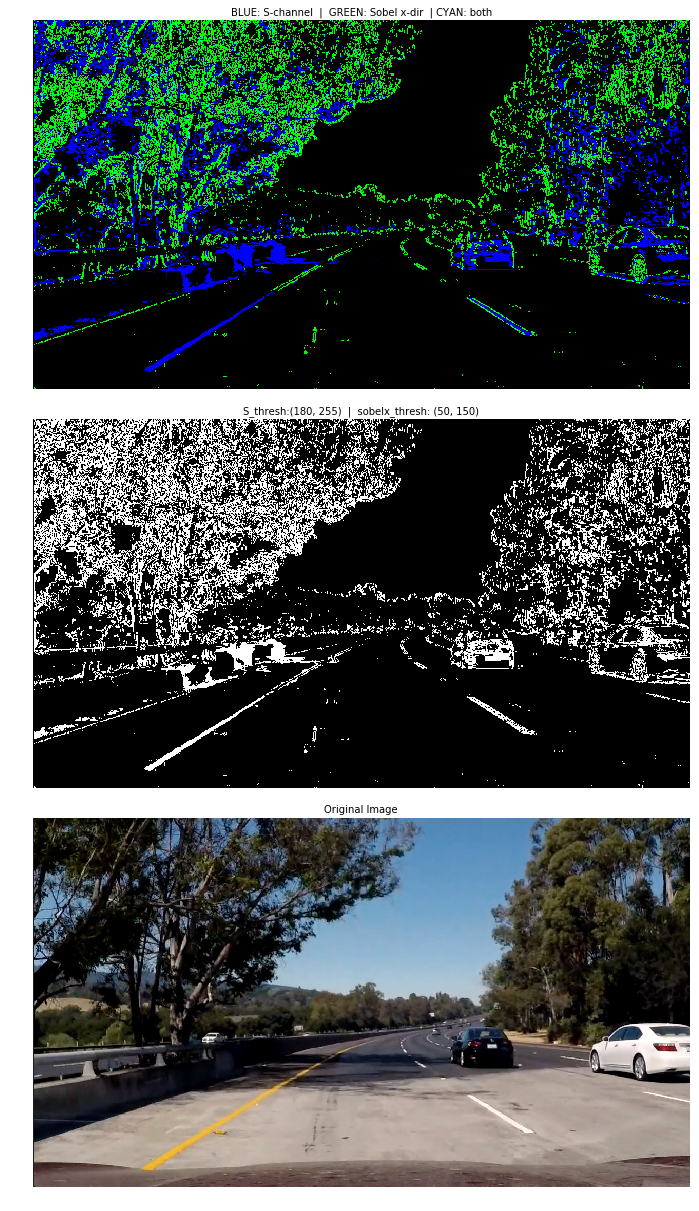

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_results(orig_image, bw_result, color_result):
    # how many images across and how many image rows
    nrows = 3  #1
    ncols = 1  #2
    # figsize must be recalculated when change nrows and ncols
    figsize = (12, 18) #1x2: (24,9)
    # fonstsize is dependant on size of subplot
    fontsize = 10 #40

    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    f, (ax1, ax2, ax3) = plt.subplots(nrows, ncols, figsize=figsize)
    f.tight_layout()

    ax1.imshow(color_result)
    ax1.set_title('BLUE: S-channel  |  GREEN: Sobel x-dir  | CYAN: both', fontsize=fontsize)
    ax1.axis('off')

    ax2.imshow(bw_result, cmap='gray')
    ax2.set_title('S_thresh:'+str(s_thresh)+'  |  sobelx_thresh: '+str(sx_thresh), fontsize=fontsize)
    ax2.axis('off')

    ax3.imshow(orig_image)
    ax3.set_title('Original Image', fontsize=fontsize)
    ax3.axis('off')

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def save_results(bw_result, color_result):
    
    import os

    # Save Images to File so can compare results of various threshold values
    settings = '_' + 's-thresh-'      +str(s_thresh[0]) +'-'+str(s_thresh[1]) + \
               '_' + 'sobel-x-thresh-'+str(sx_thresh[0])+'-'+str(sx_thresh[1])
    folder_name = './l32-my-outputs-from-color_and_gradient/'
    bw_binary_fullpath    = folder_name+'l32_bw_binary'   +settings+'.png'
    color_binary_fullpath = folder_name+'l32_color_binary'+settings+'.png'

#     # create folder if it does not already exist
#     images_path = folder_name      # remove this line if uncommented above section, (not using notebook)
#     if not os.path.isdir(images_path):
#         os.makedirs(images_path)
    create_folder_if_not_exists(folder_name)

    # convert BW to 3 channels for saving
    bw_3channel = np.zeros_like(color_result)
    bw_3channel = np.dstack((bw_result, bw_result, bw_result))

    # COULD DO: only resave files if they don't already exist!

    # save files (use mpimg, since color_result is in RGB order)
    mpimg.imsave(bw_binary_fullpath, bw_3channel)
    mpimg.imsave(color_binary_fullpath, color_result)

    print('Binary Thresholds images saved as: \n' + bw_binary_fullpath + '\n' + color_binary_fullpath)
    


def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
# def pipeline(orig_image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    ## Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. 
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    empty_channel = np.zeros_like(s_binary)
    
    # colorful green and blue stacked image (red channel is black or all zeros)
    color_binary = np.dstack(( empty_channel, sxbinary, s_binary))
    
    # BW binary combination of sxbinary and s_binary (not using)
    bw_binary = np.zeros_like(s_binary)
    bw_binary[ (sxbinary == 1) | (s_binary == 1)] = 1
    #return combined_binary 
    
    return color_binary, bw_binary 
    
    
# image = mpimg.imread('bridge_shadow.jpg')
image = mpimg.imread('l32-color-shadow-example.jpg')
    
# SET THRESHOLD VALUES HERE
s_thresh  = (180, 255) #Blue  #(140, 255)  # (90, 255) were good values from L_29
sx_thresh = ( 50, 150) #Green
    
# calculate binary images, based on threshold values above
color_result, bw_result = pipeline(image, s_thresh)

# Plot the results
plot_results(image, bw_result, color_result)

# Save Images to File so can compare results of various threshold values
save_results(bw_result, color_result)


## 3 - Perspective Transform
###### (See L_17 for more details)

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated above from cv2.calibrateCamera()
dist_pickle = pickle.load( open( "l32/wide_dist_pickle.p", "rb" ) )
mtx  = dist_pickle["mtx"]
dist = dist_pickle["dist"]


# Read in an image
img = cv2.imread('test_image2.png')

# store orig image's pixel dimensions (for use in warpPerspective)
height = img.shape[0]
width  = img.shape[1]
image_size = (width, height)


# Chessboard grid "dimensions"
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # 1) Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray_undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_undistorted, (nx,ny), None)
    #print(corners.shape, '\n', corners)
    
    # 4) If corners found:
    if ret == True:
            # a) draw corners
            # create undistorted image, with corners drawn on it
            undistorted_with_corners =  cv2.drawChessboardCorners(undistorted, (nx,ny), corners, ret)
            
            # Doesn't Work Online (either method that I tried: 1st is error, 2nd is invisible
            # # plot undistorted_with_corners image:
            # # cv2.imshow('undistorted_with_corners', undistorted_with_corners)
            # f1, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
            # f1.tight_layout()
            # ax1.imshow(undistorted_with_corners)
            # ax1.set_title('Undistorted With Corners Drawn', fontsize=50)
            # #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            # cv2.waitKey(1000)            
 
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
                 
            # I'll use grid coordinates [0,0], [0, nx-1], [ny-1, nx], [nx,ny]
            # src = np.float32([corners[0][0],         corners[7][0],  
            #                   corners[40][0],        corners[47][0]])
            # ie ordered as: TL,TR,BL,BR
            # print(corners[0][0],         corners[nx-1][0])
            # print(corners[nx*(ny-1)][0], corners[nx*ny-1][0])
            print(corners.shape)
            print('4 coordinates chosen from undistorted image:')
            src = np.float32([corners[nx*(0)][0],    corners[(nx*1) -1][0],  
                              corners[nx*(ny-1)][0], corners[(nx*ny)-1][0]]) 
            print(src, '\n')
                 
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])

            # width and height of final image (pixels) == undistorted size = img size
            width, height = (undistorted.shape[1], undistorted.shape[0])
            print(width, height)

            # width and height of squares in unwarped image (pixels)
            grid_width_x =  width/(nx+1)  # nx lines ==> nx+1 equally spaced squares
            grid_height_y = height/(ny+1)
            print(grid_width_x, grid_height_y, 'grid width, height in undistorted, transformed image')
            
            margin = 0 #15 #px
            dst = np.float32([[    0+margin+grid_width_x,      0+margin+grid_height_y], 
                              [width-margin-grid_width_x,      0+margin+grid_height_y], 
                              [    0+margin+grid_width_x, height-margin-grid_height_y], 
                              [width-margin-grid_width_x, height-margin-grid_height_y]])
                              
            print('4 corresponding coordinates on unWarped image:')
            print(dst, '\n')
            
            
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)

            # e) use cv2.warpPerspective() to warp your image to a top-down view
            image_size = (undistorted.shape[1], undistorted.shape[0])
            print(image_size)
            # warped = cv2.warpPerspective(undistorted, M, image_size, flags=cv2.INTER_LINEAR)
            warped = cv2.warpPerspective(undistorted_with_corners, M, image_size) #default: flags=cv2.INTER_LINEAR)
    else: 
        print ("corners not found, could not perform warpPerspective on undistorted img")
        print(ret, corners)
        print(nx, ny, undistorted.shape)
        # send back the grayscale undistorted image.  This will show in odd colors, standing out !
        warped = gray_undistorted #undistorted
        M = 0
            
    return warped, M, undistorted_with_corners  #gray_undistorted, #undistorted


# Get Unwarped Image
top_down, perspective_M, undist = corners_unwarp(img, nx, ny, mtx, dist)

# Plot Images:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

# Original
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)

# Undistorted
ax2.imshow(undist)
ax2.set_title('Undistort', fontsize=50)

# Perspective Warp Correction on Undistorted
ax3.imshow(top_down)
ax3.set_title('Perspective Warp', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


## L_32 Notes and Instructions

### 2 - Thresholding Notes
#### Thresholded Image Should look something like :  

<img src= "l32-binary-combo-img-example-result.jpg" width=700 />


### 3 - Perspective Transform  Notes

Next, you want to identify four source points for your perspective transform.  
In this case, you **can assume the road is a flat plane**.  
This isn't strictly true, but it can serve as an approximation for this project.  
You would like to pick four points in a trapezoidal shape (similar to region masking)  
that would represent a rectangle when looking down on the road from above.  

The easiest way to do this is to:  
  - investigate an image where the **lane lines are straight**, and  
  - find **four points** lying along the lines that, after perspective transform, would make  
  the lines look **straight and vertical** from a bird's eye view perspective.  

Here's an example of the result you are going for with straight lane lines:  

<img src="l32-warped-straight-lines.jpg" />